# Project 3 - TMA4320
## Simulation of the Action Potential with Random Walk of Ions
### Group 21 - Knut Andre Grytting Prestsveen and Henrik Elias Vatn Skaldebø

This notebook is the third project in TMA4320 at the Norwegian university of Science and Technology, and through the exercises it will simulate the action potential in cells, using random walk of ions.

The notebook and associated source code is hosted at: <a href="https://github.com/kaprests/Numerical-1D-TISE">GitHub.</a>

In [1]:
'''imports packages and constants'''
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.constants import Boltzmann as kb

In [2]:
'''Sets parameters for plotting'''
newparams = {'axes.labelsize': 15, 'axes.linewidth': 1,
             'axes.grid': True,'lines.linewidth': 1.5, 
             'figure.figsize': (12, 5),
             'ytick.labelsize': 15, 'xtick.labelsize': 15,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 15, 'legend.frameon': True, 
             'legend.handlelength': 1.5, 'axes.titlesize': 20,
             'mathtext.fontset': 'stix', 'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

## 2 - The Diffusion Equation

### Exercise 2.1
Show that the function

$$ 
\tilde{\phi}(x,t) = \frac{1}{\sqrt{4 \pi Dt}} e^{-\frac{(x-\mu)^2}{4Dt}},
$$

where $D$ is a constant, is a solution of the diffusion equation

$$
\frac{\partial \phi (x,t)}{\partial t} = D \frac{\partial^2 \phi (x,t)}{\partial x^2}.
$$

**Solution:**

The left side of the equation is solved by differentiating with respect to $t$.

$$
\frac{\partial}{\partial t} \frac{1}{\sqrt{4 \pi Dt}} e^{-\frac{(x-\mu)^2}{4Dt}} 
= 
\left( \frac{1}{\sqrt{4 \pi Dt}} \right)' e^{-\frac{(x-\mu)^2}{4Dt}} 
+ 
\frac{1}{\sqrt{4 \pi Dt}} \left(e^{-\frac{(x-\mu)^2}{4Dt}}\right)' 
=
- \frac{1}{4\sqrt{D\pi}t^{3/2}}e^{-\frac{(x-\mu)^2}{4Dt}} 
+
\frac{(x-\mu)^2}{(4D)^{3/2}\sqrt{\pi}t^{5/2}}e^{-\frac{(x-\mu)^2}{4Dt}}
=
\frac{1}{\sqrt{4 D \pi t}} e^{-\frac{(x-\mu)^2}{4Dt}}
\left(\frac{(x-\mu)^2}{4Dt}-\frac{1}{2t} \right) = \tilde{\phi}(x,t) \left(\frac{(x-\mu)^2}{4Dt}-\frac{1}{2t} \right)
$$

The right side is then solved by differentiating twice with respect to $x$, times the constant $D$.

$$
\frac{\partial}{\partial x} \frac{1}{\sqrt{4 \pi Dt}} e^{-\frac{(x-\mu)^2}{4Dt}} = - \frac{2(x-\mu)}{(4Dt)^{3/2}\sqrt{\pi}}e^{-\frac{(x-\mu)^2}{4Dt}}
$$
<br>
$$
-\frac{\partial}{\partial x} \frac{2(x-\mu)}{(4Dt)^{3/2} \sqrt{\pi}} e^{-\frac{(x-\mu)^2}{4Dt}}
=\frac{2(x-\mu)}{(4Dt)^{3/2}\sqrt{\pi}} \left( e^{-\frac{(x-\mu)^2}{4Dt}} \right)' 
-\left( \frac{2(x-\mu)}{(4Dt)^{3/2}\sqrt{\pi}}\right)' e^{-\frac{(x-\mu)^2}{4Dt}}
=\frac{4(x-\mu)^2}{(4Dt)^{5/2}\sqrt{\pi}} e^{-\frac{(x-\mu)^2}{4Dt}} 
-\frac{2(x-\mu)}{(4Dt)^{3/2}\sqrt{\pi}} e^{-\frac{(x-\mu)^2}{4Dt}}
=\frac{1}{\sqrt{4\pi Dt}} e^{-\frac{(x-\mu)^2}{4Dt}}
\left(\frac{(x-\mu)^2}{4D^2t}-\frac{1}{2Dt} \right)
$$
<br>
$$
D \frac{\partial^2 \tilde{\phi}(x,t)}{\partial x^2} = \tilde{\phi}(x,t)\left(\frac{(x-\mu)^2}{4Dt}-\frac{1}{2t} \right)
$$

The function $\tilde{\phi}(x,t)$ is therefore a solution of the diffusion equation.

### Exercise 2.2
#### 2.2.1

Suppose we have an infinite 1D system with constant diffusion coefficient D. With the particle distribution

$$
\phi (x, 0) = \delta (x-x_0),
$$

where $\delta (x)$ is the Dirac delta function, the time derivative can be found by using the diffusion equation. Firstly the Dirac delta function can be represented with the integral

$$
\phi (x, 0) =  \delta (x-x_0) = \frac{1}{2\pi} \int_{- \infty}^{\infty} dk e^{-ik(x-x_0)}.
$$

Differentiating twice with respects to $x$ and multiplying with $D$ gives the time derivative of $\phi(x, t)$.

$$
\frac{\partial \phi(x, t)}{\partial t} = D \frac{\partial^2 \phi (x,t)}{\partial x^2} = - \frac{Dk^2}{2\pi} \int_{- \infty}^{\infty} dk e^{-ik(x-x_0)}
$$

The Taylor expansion of $\phi(x, t)$ is

$$
\phi(x, t) = \phi (x, 0) + \sum_{n=1}^{\infty} \frac{t^n}{n!} \frac{\partial^n \phi(x,t')}{\partial t'^n} \Bigg|_{t'=0}.
$$

To expand the sum, the previous process can be used to further differentiate $\phi(x, t)$

$$
\phi(x, t) = \frac{1}{2\pi} \int_{- \infty}^{\infty} dk e^{-ik(x-x_0)} 
-\frac{Dk^2t}{2\pi} \int_{- \infty}^{\infty} dk e^{-ik(x-x_0)} 
$$
<br>
$$
+\frac{Dk^4t^2}{2\pi2!}\int_{- \infty}^{\infty}dke^{-ik(x-x_0)}
-\cdots.
$$

Every element of the sum is thereby given as
$$
(-1)^n \frac{Dk^{2n}t^n}{2\pi n!}\int_{- \infty}^{\infty}dke^{-ik(x-x_0)}, \quad n=1,2,3...\infty.
$$

This pattern makes it possible to write

$$
\phi (x,t) = \frac{1}{2\pi} \int_{- \infty}^{\infty}dke^{-ik(x-x_0)} \left( 1 - Dk^2t + \frac{Dk^4t^2}{2!} - \frac{Dk^6t^3}{3!} \pm\cdots \right).
$$

The expression inside the parentheses resembles the Maclaurin series for $e^x$

$$
e^{-Dk^2t} = 1 - Dk^2t + Dk^4t^2 - Dk^6t^3\cdots.
$$

The particle distribution is now neatly expressed as
$$
\phi(x, t) = \frac{1}{2\pi}\int_{- \infty}^{\infty}dk e^{-Dk^2t} e^{-ik(x-x_0)}.
$$

To solve this integral, it would be wise to rewrite it as

$$
\frac{1}{2\pi}\int_{- \infty}^{\infty}dk e^{-Dk^2t -ik(x-x_0)} 
= \frac{1}{2\pi}\int_{- \infty}^{\infty}dk e^{ - \frac{(x-x_0)^2}{4Dt} - \left( k\sqrt{Dt} + \frac{i(x-x_0)}{2\sqrt{Dt}} \right)^2}
= \frac{1}{2\pi} e^{ - \frac{(x-x_0)^2}{4Dt}} \int_{- \infty}^{\infty}dk e^{\left( k\sqrt{Dt} + \frac{i(x-x_0)}{2\sqrt{Dt}} \right)^2}.
$$

By using the substitution $u = k\sqrt{Dt} + \frac{i(x-x_0)}{2\sqrt{Dt}}$, with $dk = \frac{du}{\sqrt{Dt}}$, the integral is simply

$$
\frac{1}{\sqrt{4Dt}\pi} e^{ - \frac{(x-x_0)^2}{4Dt}} \int_{- \infty}^{\infty} e^{-u^2}du.
$$

This integral is the Gaussian integral $\int_{\infty}^{\infty} e^{-u^2}du = \sqrt{\pi}$ solving the problem.

$$
\phi(x, t) = \frac{1}{\sqrt{4\pi Dt}} e^{ - \frac{(x-x_0)^2}{4Dt}}
$$


#### 2.2.2
Inspection of the resulting $\phi(x, t)$ in the previous task, and comparisson with a general normal distribution

$$
f(x| \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}},
$$

makes it clear that $\phi(x, t)$ simply is a normal distribution with variance $\sigma^2 = 2Dt$ and expectation value $\mu = x_0$. Variance is a measure of the spread of the distribution and is linear with time, $t$. The diffusion constant, $D$, is therefore a measure of how quickly a substance diffuses.

#### 2.2.3
Given another initial condition $\phi (x, 0) = g(x) = \delta (x-x_0)$ the time evolution can be found by using a linear combination of the result from 2.2.1.

$$
\phi(x, t) = \frac{1}{\sqrt{4 \pi D t}} \sum^{\infty}_{n = - \infty} c_n e^{- \frac{(x-x_0)^2}{4Dt}},
$$

where

$$
\phi(x, 0) =  \sum^{\infty}_{n = - \infty} c_n \delta (x-x_0) = \int_{- \infty}^{\infty} g(y)\delta(x-y)dy=g(x).
$$

The time evolution is now given as 

$$
\phi(x, t) = \frac{1}{\sqrt{4 \pi D t}} \int_{- \infty}^{\infty} g(y) e^{- \frac{(x-x_0)^2}{4Dt}}dy.
$$

## 3 - Random Walk of Free Ions

Here, diffusion of 1000 particles in a constant, uniform (zero) potential, is simulated using random walk. The simulation is run for 100 time steps, and each particle may move one step to the left or right with equal probability at each time step. The resulting distribution of the particles is plotted along with a fitted curve for the probability distribution of the particles position.

The random walk is simulated by keeping track of each particles position in a numpy array, and for each time step generate a vector containing the steps of each particle, which is either +1 or -1, with a probability of 50% for each. The probability of a particle staying still is zero, just to simplify the simulation.

In [3]:
'''
Task 3 - programming

This is the main code for task 3 and 5. It defines a system of 1000 particles and simulates random walk in
given potentials.
'''

N = 1000 # number of particles
steps = 100 # number of steps in the random walk simulation
particles = np.zeros(N) # vector containing the initial position (x=0) of all particles
h = 1 # length of a step taken by each particle per step/unit time delta t
T=1 # Temperature, arbitrarily defined, just a constant
beta_k = 0.1 # product of the two constants beta and k, relevant for task 5
beta = 1/(kb*T) # constant beta, kb is Boltzmanns constant and T is the temperature
k = beta_k/beta # extract konstant k from beta*k


# For task 3 (V = 0) Pm = 0.5
# P_min is therefore only relevant for task 5 and onwards when V != 0
def P_min(x, V):
    """
    calculates probability for a particle at position x in a potential V to take a step to the left.
    
    Input:
        x: position of a particle.
        V: the potential.
    Output:
        Pm: the probability for a given particle to take a step to the left.
    """
    V1 = V[steps+int(x)-h]
    V2 = V[steps+int(x)+h]
    # beta_k in the exponent, since k is factored out of the potentials too keep stuff dimensionless an minimize numerical clutter
    rel_prob = np.exp(-beta_k*(V1 - V2))
    Pp = 1/(1 + rel_prob)
    Pm = 1 - Pp
    return Pm


def rand_walk(p_pos, V):
    """
    Runs the actual random walk simulation, updates the positon of all particles and computes data for 
    curve fitting.
    
    Input:
        p_pos : array containing the (initial) position of all particles
        V : the potential
    Output:
        params : parameters for fitted data curve
    """
    for j in range(steps):
        steps_vec = np.random.rand(N)
        for i in range(p_pos.size):
            if steps_vec[i] >= P_min(p_pos[i], V):
                steps_vec[i] = 1
            else:
                steps_vec[i] = -1
        p_pos += steps_vec
        params = norm.fit(p_pos)
    return params


def plot_distribution(p_pos, V, V_name, fit=False):
    """
    plots the resulting distribution and the fitted probability density for the particles position. 
    
    Input:
        P_pos : (initial) position of all particles
        V : the potential
        V_name : title of the plot
    """
    params = rand_walk(p_pos, V)
    x_vec = np.arange(min(p_pos), max(p_pos))
    fitted_pdf = norm.pdf(x_vec, loc = params[0], scale = params[1])
    fig, ax1 = plt.subplots()
    ax1.hist(p_pos, bins=np.arange(min(p_pos), max(p_pos), 2), label='Particle distribution')
    ax1.set_xlabel("Position")
    ax1.set_ylabel("number of particles")
    if fit:
        ax2 = ax1.twinx()
        ax2.plot(x_vec, fitted_pdf, color="r", label='Probability density function')
        ax2.set_ylabel("probability")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc=2)
        print("mean: ", params[0], "\nvar: ", params[1]**2)
    plt.title(V_name)
    plt.show()


mean:  -0.544 
var:  96.024064


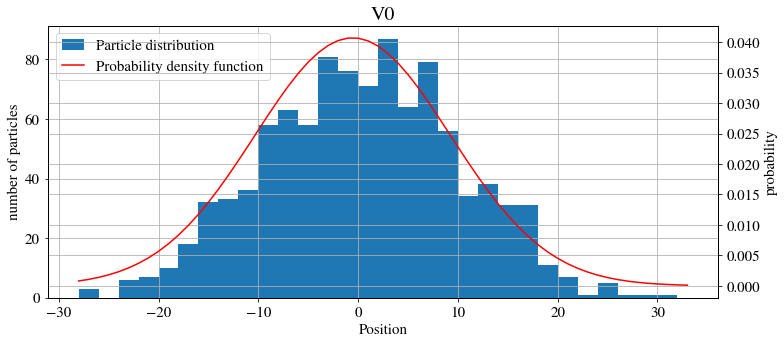

In [4]:
"""
This cell defines the potential for task 3, runs the simualtion and plots the results
"""

# zero potential, vectorizing is not a pretty solution, and V0 is strictly not a necessary function, but is 
# included for generalitys sake.
V0 = lambda x: 0
V0 = np.vectorize(V0)

# Generates V0_vec, a vector with value of the V0 potential in all positions
V_vec = np.arange(-steps, steps+1)
V0_vec = V0(V_vec)

# runs simulation, plots and resets the system
plot_distribution(particles, V0_vec, "V0", True)
particles = np.zeros(N)

From theory section 1 it's known that the particle distribution should correspond to the diffusion equation. Exercise 2.2.1 shows that the distribution $\phi (x, t)$ for an infinite 1D system with constant diffusion constant $D$ is a normal distribution in $x$. When simulating random walk with a stochastic process as in this task, it would therefore be expected to result in a distribution similar to a normal distribution. As seen in the plot of the distribution this fits nicely. Additionally the mean value is close to zero and the variance is proportionate with the number of time steps.

## 5 - Random Walk in Time Independent Potentials

In task 5.1 through 5.3 the random walk simulation is run for the different time independent potentials V1, V2 and V3. The function P_min calculates the probability treshhold for a particle to move either right or left, which is 0.5 for a uniform potential as in task 3. Depending on the potential, the particles prefer to move either to the right or to the left, and thus we end up with different particle distributions.

The simulation is also run for multiple values of $\beta k$, $\beta k \in \{0.1, 1, 3 \}$ , which is a constant giving the ratio between thermal and potential energy of the system. Higher $\beta k$ means larger potential energy relative to the thermal energy.

In [5]:
'''
Task 5 - programming

Defines some non uniform potentials and runs the simulation with them.

As explained above the constant k is factored out of the potential functions and multiplied back in in the
exponent function in P_min.
'''

# Exercise 5.1 - linear potential
V1 = lambda x: x


# Exercise 5.2 - box potential
def V2(x):
    if -3*h < x and x < 3*h:
        return 1
    else:
        return 0


# Exercise 5.3 - descriptive name of this potential??
def V3(x):
    if x < -3*h:
        return -1
    elif -3*h < x and x < 3*h:
        return (-1 + 2 * ((x + 3*h)/(6*h)))
    else:
        return 1


# Vectorize functions, this is not a pretty solution, but performance is not to much of an issue here.
# It also lets the potential definitons to be written in an intuitive way.
V1 = np.vectorize(V1)
V2 = np.vectorize(V2)
V3 = np.vectorize(V3)

# Vectors containing the potential values in all positions
V1_vec = V1(V_vec)
V2_vec = V2(V_vec)
V3_vec = V3(V_vec)

# Various values of the dimensionless constant beta*k
beta_k_list = [0.1, 1, 3]


### 5.1 Linear Potential

$$
V(x) = k \cdot x
$$

The linear potential gives a simulation of ions diffusiong with a constant drift to the left, and we expect resulting distributions that are skewed to the left. With higher $\beta k$ the random vibration due to thermal energy has less impact on the ions movement compared to the potential gradient, and the diffusion is therfore in this case expected to be less random and more skewed to the left.

Running the code cell below shows exactly the expected behaviour described above, and for $\beta k = 3$, the particles are all pretty much crammed up on the left side.

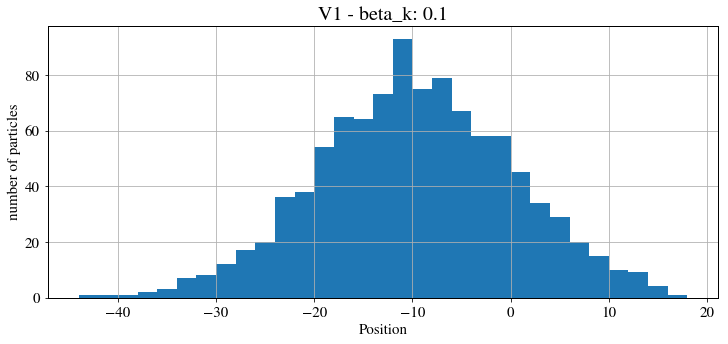

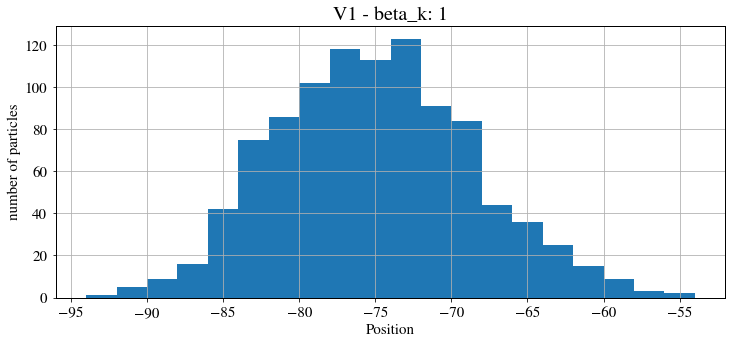

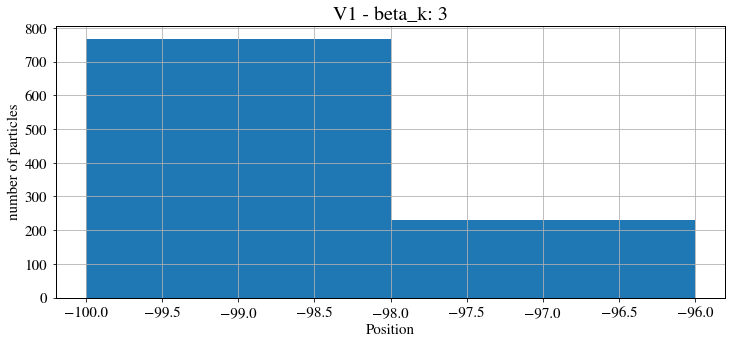

In [6]:
for elem in beta_k_list:
    beta_k = elem
    stringV1 = "V1 - beta_k: {}".format(elem)
    plot_distribution(particles, V1_vec, stringV1)
    particles = np.zeros(N)

### 5.2 - Box Potential

$$
V = \begin{cases}
        k & \text{, $-3h < x < 3h$}\\
        0 & \text{, otherwise}
    \end{cases}
$$

This potential consists of two regions with zero potential, sepparated by a potential barrier in the middle, which in our case may represent two regions, sepparated by a membrane. When the potential energy of the barrier is low compared to the thermal energy (low $\beta k$), a random walk in this potential should be little different from random walk of free particles, but for higher $\beta k$, the particles are expected to move away from the barrier/membrane area where they have higher potential energy. The simualtion is therefore expected to result in a distribution with a split in the middle, which should get more defined for higher values of $\beta k$.

Again, running the code below generates distributions that fits very well with the expected results.

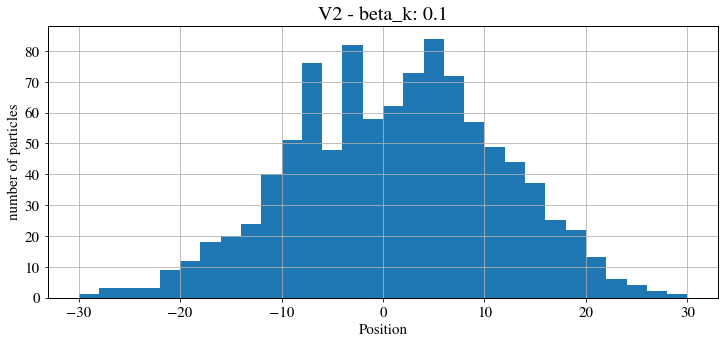

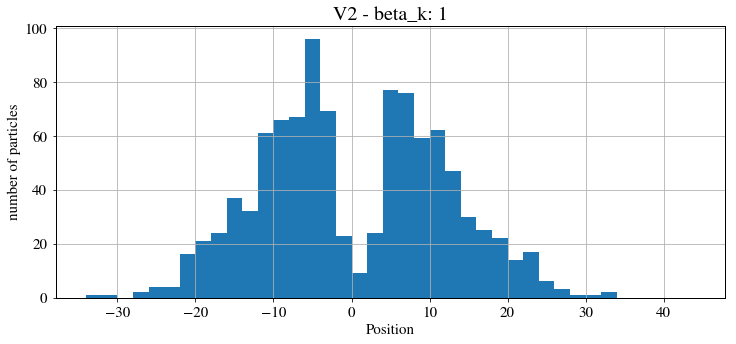

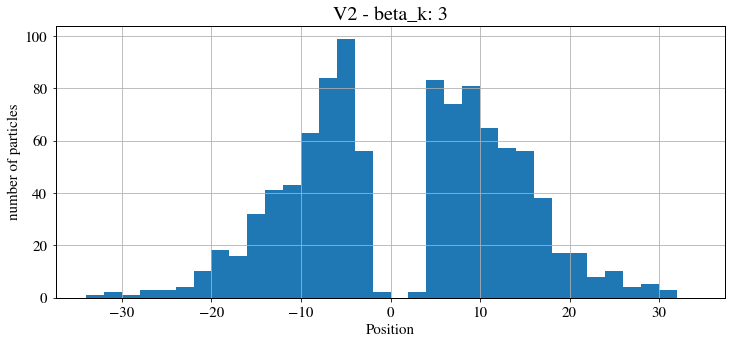

In [7]:
for elem in beta_k_list:
    beta_k = elem
    stringV2 = "V2 - beta_k: {}".format(elem)
    plot_distribution(particles, V2_vec, stringV2)
    particles = np.zeros(N)

### 5.3 - Membrane with Constant Electrical Resistance

$$
V = \begin{cases}
        -k & \text{, $x < -3h$}\\
        k(-1 + 2\frac{x + 3h}{6h}) & \text{, otherwise}\\
        k & \text{, $x > 3h$}\\
    \end{cases}
$$

This potential may also model two regions sepparated by a barrier, but also the electrical potential felt by the ions when the sepparating membrane has a constant electrical resistance. When $\beta k$ is low, the thermal energy dominates, and the expected end distribution is something very close to a normal distribution as in task 3. For higher $\beta k$ values however the potential energy is more significant, and ions in the membrane is expected to jump down the potential slope and end up on the right side. Since the potential gradient is zero in the regions right and left of the membrane, there is no drifting force in these regions, and the particles are therefore expected to somewhat pile up just left of the membrane.

Running the simulation by running the cell shows roughly the expected behaviour, but it looks like the partices are mostly piling up inside the membrane for $\beta k = 3$, a litte more to the right than expected. Not really sure as to why this happens, either we have misunderstood the behaviour of random walk in this potential, or there is a small bug in the code that we're unable to find.

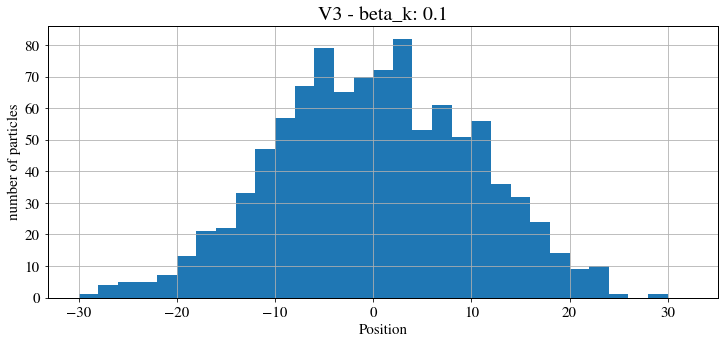

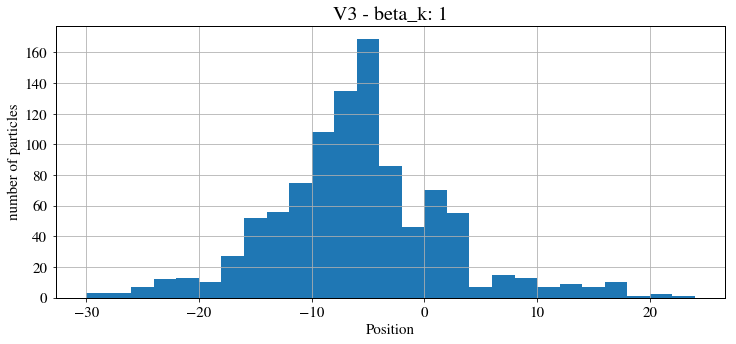

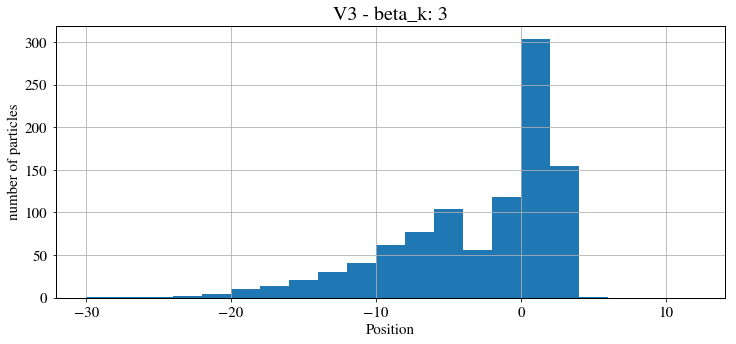

In [8]:
for elem in beta_k_list:
    beta_k = elem
    stringV3 = "V3 - beta_k: {}".format(elem)
    plot_distribution(particles, V3_vec, stringV3)
    particles = np.zeros(N)

## 7 - Interplay Between Diffusion and Voltage
With similar system parameters as before, and a cell membrane at $-h \leq x \leq h$, a simplified action potential cycle with random walk will now be simulated. The inside of the cell is defined as to the left of the described membrane, while the outside of the cell is to the right. Additionally the system has edges at $\pm L/2$ where the particles cannot pass. For each ion, sodium and potassium, the membrane potential is respectively $V^0_{Na}$ and $V^0_{K}$ at $-h \leq x \leq h$ and zero elsewhere. 

Between the interior and exterior of the cell there's an electric potential difference $V(t)$ equal for both ions. For this problem the voltage can be written as

$$
V(t) = \frac{[Q(t)]^+}{C_c},
$$

where $[Q(t)]^+$ is the charge concentration difference of both sides of the membrane. With ion concentrations and resting potential as in the project note, the concentration capacitance $C_c$ is approximaly $0.7e$ M/V, where $e$ is the elemental charge.

Just as we defined the dimensionless constant $\beta k$, we now define $\beta V^0_{Na}$ and $\beta V^0_{K}$, which gives the ration between the thermal and potential energies of the ions. Again with $\beta = 1/k_BT$ where $k_B$ is Boltzmanns constant and the temperature is now $T = 273+37$ K as it would be in a human body.

In [9]:
'''Task 7-8
Simulates action potential with random walk, code based on task 3 and 5. 
The simulation can be run with or without SSP and regulating the voltage according to minimum and maximum value.
'''

#import numpy as np
#from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as elemc


h = 1 # step length for the particles
L = 50 # units of h. Length of system
T = 273 + 37 # K, (body) temperature
beta = 1/(kb*T) # Typical thermodynamic parameter, kb is Boltzmanns constant, T is the temperature 
Cc = 0.07*elemc*1e3 #CmMC/V, the capacitance of the cell membrane
Qc_out = 150 #mM, charge concentration outside of the cell, this stays constant
C_p = 0.1 # mM, concentration per particle, each particle in our simulation represents C_p ions
N_Na = 50 + 1450 # Number of sodium particles
N_K = 1400 + 50 # Number of potassium particles

steps = 500 # base number of time steps in the simulations
timesteps = np.arange(steps) # ordered vector containing each time step
pos_vec = np.arange(-steps, steps +1) # All possible positions in the system
betaV0_Na = 0 # beta * V0_Na, beta = 1/kb*T, V0 some constant and kb = Boltzmanns constant
betaV0_K = 0 # beta * V0_K, beta = 1/kb*T, V0 some constant and kb = Boltzmanns constant

# Relevant for task 8
# Regulates potential according to voltage difference
min_vol = -70e-3 #V, voltage at which channels open/close
max_vol = 30e-3 #mV, voltage at which channels open/close
betaV_open = 1 # dimensionless, value of an open channel potential, multiplied by beta

# A function to prepare the system according to specified configurations
# Also sets the initial position of the particles
def prep(bV0_Na, bV0_K, t_steps=500):
    '''
    Prepares the system in an initial state by setting global parameters used in the simualtion.
    
    Input:
        bV0_Na: the dimensionless value for the membrane potential for Na
        bV0_K: the dimensionless value for the membrane potential for K
        t_steps: number of steps, default set to 500
    '''
    global steps
    steps = t_steps
    global timesteps
    timesteps = np.arange(steps)
    global pos_vec
    pos_vec = np.arange(-steps, steps +1)
    global betaV0_Na
    betaV0_Na = bV0_Na
    global betaV0_K
    betaV0_K = bV0_K
    global Na_pos
    Na_pos = np.array([-L//4]*50 + [L//4]*1450)
    global K_pos
    K_pos = np.array([-L//4]*1400 + [L//4]*50)
    

# potentials
def V_channel(pos_vec, V_0):
    '''
    sets the channel potential strengths as vectors
    
    Input:
        pos_vec: vector containing system positions
        V_0: potential
    Output:
        V_vec: vector with the potential strenght at positions corresponding to the cell membrane
                and zero elsewhere
        '''
    channel_vec = np.array([V_0]*(2*h +1))
    zero_vec = np.zeros((pos_vec.size - channel_vec.size)//2)
    V_vec = np.concatenate((zero_vec, channel_vec))
    V_vec = np.concatenate((V_vec, zero_vec))
    return V_vec


# Time dependent potential
def V_elec(Na_pos, K_pos):
    '''
    calculates the potential difference between the interior and exterior of the cell
    
    Input:
        Na_pos: vector containing the positions of all Na ions
        K_pos: vector containing the positions of all K ions
    Output:
        elemc*Qc/Cc (Ve): the potential difference
    '''
    Na_in = Na_pos[Na_pos < -h].size
    K_in = K_pos[K_pos < -h].size
    Qc_in = (Na_in + K_in)*C_p
    Qc = Qc_in - Qc_out
    return elemc*Qc/Cc #volts


# Returns probability of a single particle stepping to the left
def P_min(x, V_vec):
    """
    calculates probability for a particle at position x in a potential V to take a step to the left.
    
    Input:
        x: position of a particle.
        V: the potential.
    Output:
        Pm: the probability for a given particle to take a step to the left.
    """
    V1 = V_vec[steps + int(x) -h]
    V2 = V_vec[steps + int(x) +h]
    rel_prob = np.exp(-beta*(V1 - V2))
    Pp = 1/(1 + rel_prob)
    Pm = 1 - Pp
    return Pm


# Pumps ions in and out membrane, step counter defined in rand_walk()
def pump(Na_pos, K_pos):
    '''
    moves the three interior sodium ions closest to the membrane outside, and the two exterior potassium ions
    closest to the membrane inside
    
    Input:
        Na_pos: vector containing the positions of all Na ions
        K_pos: vector containing the positions of all K ions
    '''
    N_Na_in = Na_pos[Na_pos < -h].size
    N_K_out = K_pos[K_pos > h].size
    if N_Na_in <= 3 or N_K_out <= 2:
        return False
    Na_pos.sort()
    K_pos.sort()
    Na_index = np.argwhere(Na_pos < -h)
    K_index = np.argwhere(K_pos > h)
    Na_pos[Na_index[-3:]] = h
    K_pos[K_index[:2]] = -h
    return True


# Function looping through time and performing the simulation. Returns a vector with the
# time dependent potential values at each time step.
def random_walk(Na_pos_vec, K_pos_vec, V_Na_vec, V_K_vec, p_vec, V_el_func, P_min_func, V_reg, spp):
    '''
    runs the actual simulation
    
    Input: 
        Na_pos_vec: vector containg starting positions for Na ions
        K_pos_vec: vector containg starting positions for K ions
        V_Na_vec: potential vector for Na
        V_K_vec: potential vector for K
        p_vec: vector containing all possible positions in system
        V_el_func: the function V_elec()
        P_min_func: the function P_min()
        V_reg: bool value to check if voltage should be regulated as in task 8
        spp: bool value to check if spp should be activated as in task 8.2
    
    Output:
        Ve_vec: vector containing the potential difference for each time step
    '''
    # array to store values of the time dependent potential
    Ve_vec = np.zeros(steps)
    
    # counter for number of steps used in pump
    count = 1

    # Loop over each time step
    for i in range(steps):
        # Calculate time dependent potential for the current timestep and store it in Ve_Vec
        Ve = V_el_func(Na_pos_vec, K_pos_vec)
        Ve_vec[i] = Ve
        
        # Regulate voltage, turn channels off and on 
        if V_reg:
            if Ve <= min_vol:
                V_Na_vec[V_Na_vec != 0] = betaV_open/beta
                V_K_vec[V_K_vec != 0] = betaV0_K/beta
            if Ve >= max_vol:
                V_Na_vec[V_Na_vec != 0] = betaV0_Na/beta
                V_K_vec[V_K_vec != 0] = betaV_open/beta
            

        # add Ve to the time independent potential vectors to get total potential
        V_Na_tot = V_Na_vec + np.heaviside(-p_vec, 0.5)*Ve*elemc
        V_K_tot = V_K_vec + np.heaviside(-p_vec, 0.5)*Ve*elemc

        # Generate vectors with 1 and -1 (vector containing the next step for each particle)
        steps_vec_Na = np.random.rand(Na_pos_vec.size) # vector with probabilities
        steps_vec_K = np.random.rand(K_pos_vec.size) # vector with probabilities
        # loop over all probabilities and determine if it should be a step to the right or left
        for j in range(steps_vec_Na.size):
            if steps_vec_Na[j] >= P_min_func(Na_pos_vec[j], V_Na_tot):
                steps_vec_Na[j] = 1
        for j in range(steps_vec_K.size):
            if steps_vec_K[j] >= P_min_func(K_pos_vec[j], V_K_tot):
                steps_vec_K[j] = 1
        steps_vec_Na[steps_vec_Na != 1] = -1
        steps_vec_K[steps_vec_K != 1] = -1

        # Have every particle take one step according to the step vector
        Na_pos_vec += steps_vec_Na.astype(int)
        K_pos_vec += steps_vec_K.astype(int)

        # boundaries at +- L/2, if a particle is on the boundary it has to move one step into the system
        Na_pos_vec[Na_pos_vec < -L/2] = -L/2 + 1
        Na_pos_vec[Na_pos_vec > L/2] = L/2 - 1
        K_pos_vec[K_pos_vec < -L/2] = -L/2 + 1
        K_pos_vec[K_pos_vec > L/2] = L/2 - 1
        
        # SPP
        # if spp is true, pump() will run every ten steps and reset the counter to 1 as long as there are enough ions
        # on each side to execute pump()
        if spp:
            if count == 10:
                if pump(Na_pos_vec, K_pos_vec):
                    count = 1
            if count < 10:
                count += 1
    
    return Ve_vec


# Plotting function
def plot_dist(Na_pos_vec, K_pos_vec, p_vec, V_el_func, P_min_func, V_ch_func, t_vec, bV0_Na, bV0_K, V_reg=False, spp=False):
    '''
    runs rand_walk() and plots the resulting potential difference vector in addition to the distribution of Na and K ions
    
    Inputs:
        Same input parameters as rand_walk(), with the boolian values set to False as default
    '''
    V_Na = V_channel(p_vec, bV0_Na/beta)
    V_K = V_channel(p_vec, bV0_K/beta)
    
    Ve_vec = random_walk(Na_pos_vec, K_pos_vec, V_Na, V_K, p_vec,  V_el_func, P_min_func, V_reg, spp)

    plt.hist(Na_pos_vec, bins="auto")
    plt.title('Distribution of sodium ions')
    plt.xlabel('Position')
    plt.ylabel('number of particles')
    plt.show()
    plt.hist(K_pos_vec, bins="auto")
    plt.title('Distribution of potassium ions')
    plt.ylabel('number of particles')
    plt.xlabel('Position')
    plt.show()
    plt.title('Time dependent electric potential')
    plt.plot(t_vec, Ve_vec)
    plt.ylabel('V(t)')
    plt.xlabel('Steps: t')
    plt.show()


### 7.1
In the following simulations there's 1450 sodium ions and 50 potassium ions outside the cell initially released at $x = L/4$. Inside the cell there's 1400 potassium ions and 50 sodium ions released at $x = -L/4$. In this task, the simulation is run for 500 time steps with $\beta V^0_{Na} = \beta V^0_{K} = \beta V^0$, and $\beta V^0 \in \{0,1,3\}$.


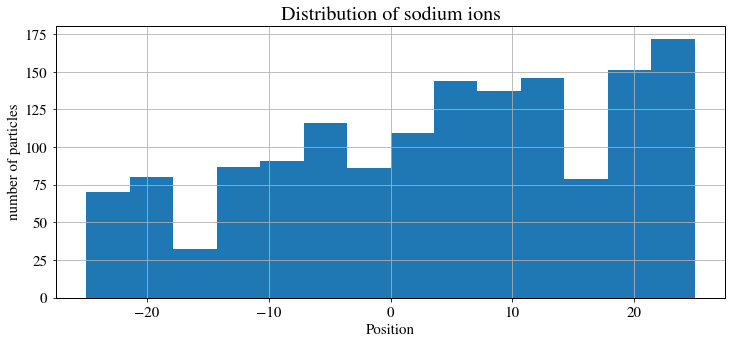

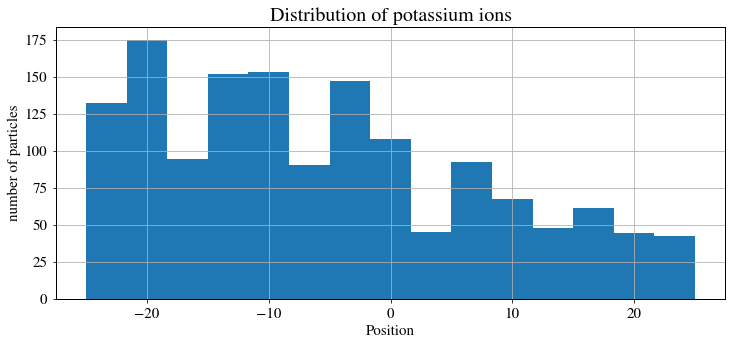

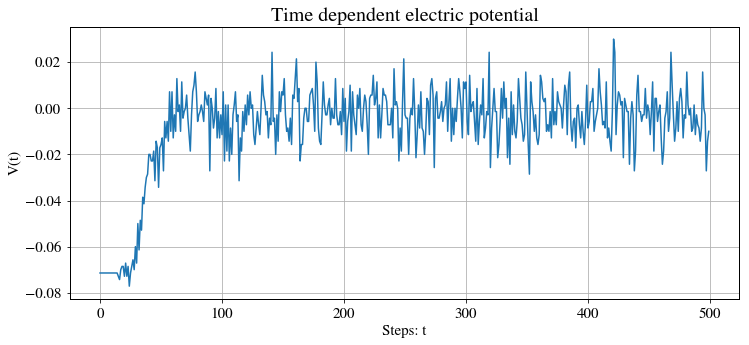

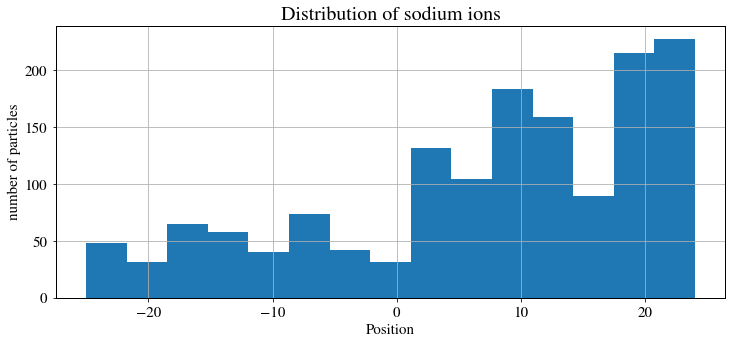

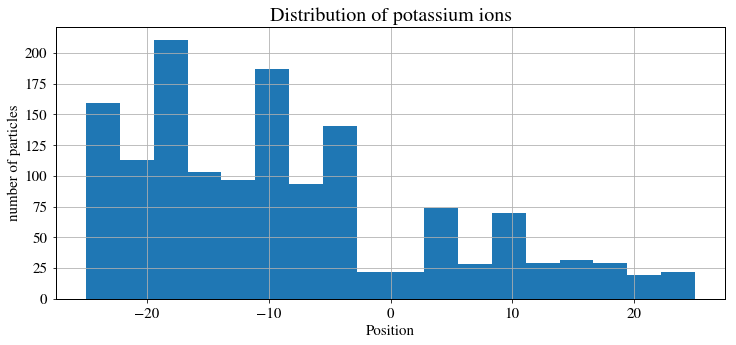

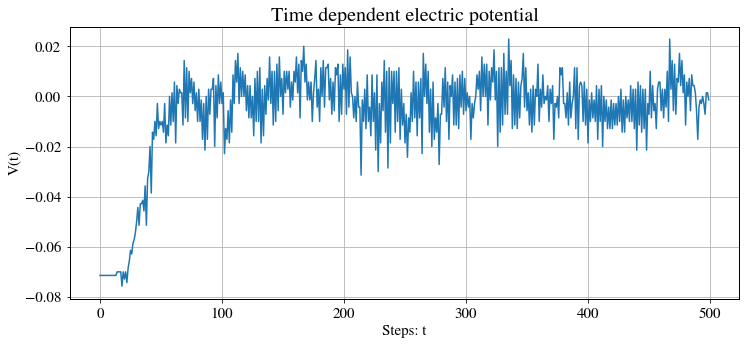

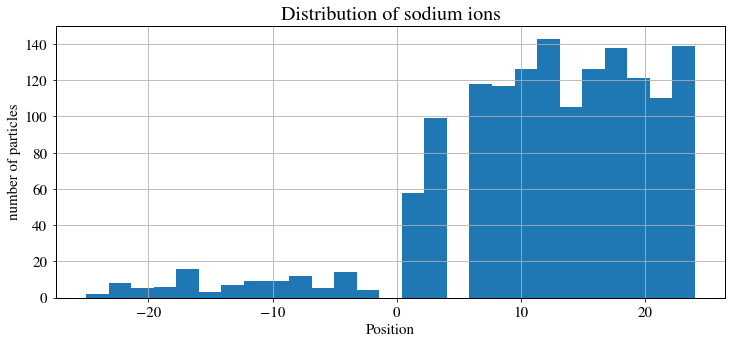

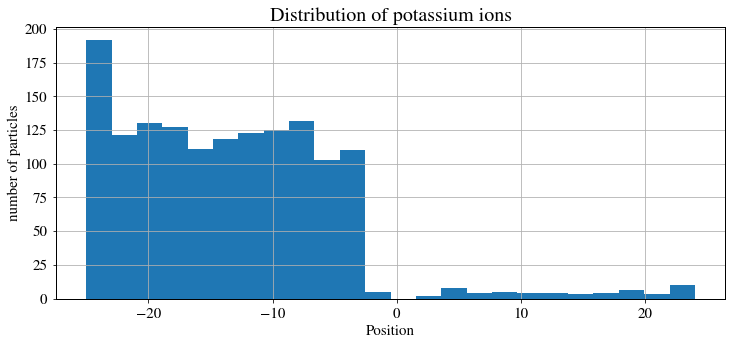

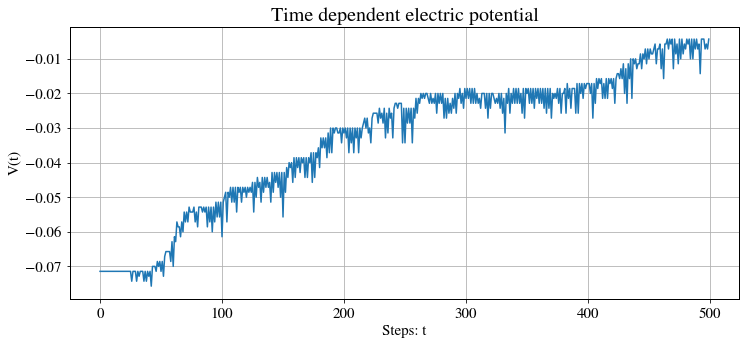

In [10]:
'''Task 7.1'''

prep(0,0)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K)

prep(1,1)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K)

prep(3,3)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K)


For the three membrane potential strenghts corresponding to $\beta V^0 \in \{0,1,3\}$, the voltage settles around $0V$. This is to be expected when the concentration of ions inside the membrane approaches the concentration of ions outside. With a negative voltage over the membrane, the sodium ions will flow into the cell along the diffusion and voltage gradient. Potassium ions will flow through the membrane and to the outside of the cell because of the diffusion gradient, however more sparsely because it has to go against the electric potential. As the voltage increases, the flow of ions in and out will become more balanced between the respective ions. This is why the voltage settles around zero, since concentration of ions inside the cell approaches the outside concentration. The system therefore reaches its equilibrium by the diffusion effect.

### 7.2
The simulation is now run with $\beta V^0_{Na} \neq \beta V^0_{K}$, once with $\beta V^0_{Na} = 1$ and $\beta V^0_{K} = 10$ and secondly with $\beta V^0_{Na} = 10$ and $\beta V^0_{K} = 1$. 

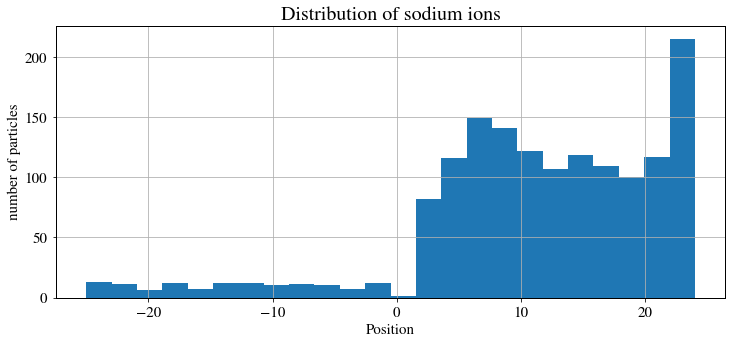

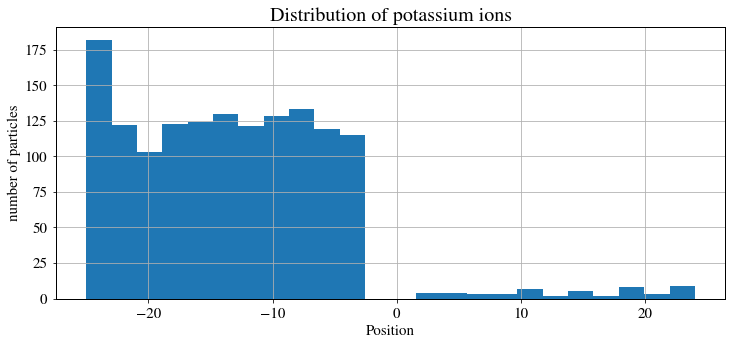

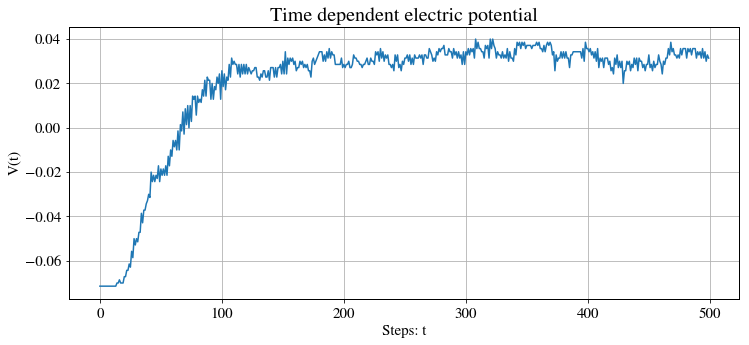

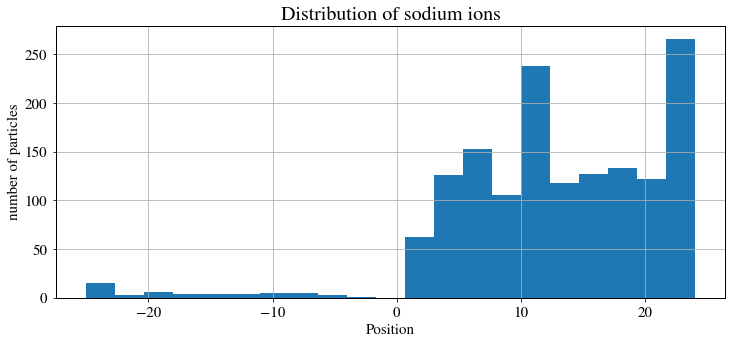

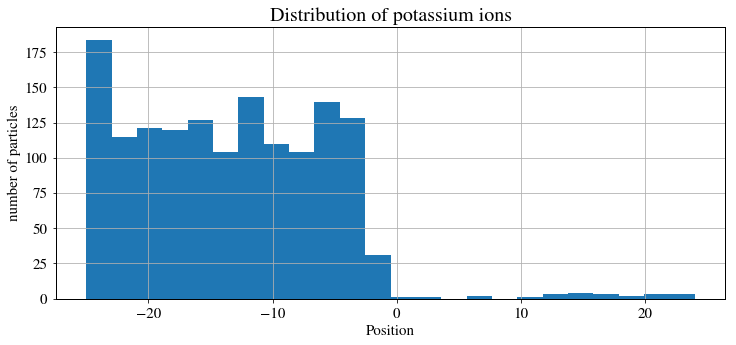

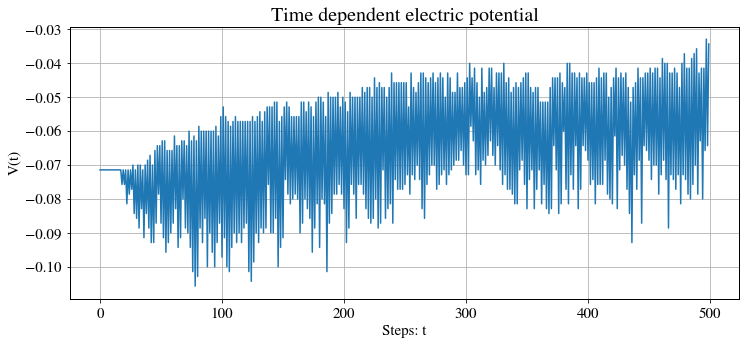

In [11]:
'''Task 7.2'''

prep(1, 10)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K)

prep(10, 1)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K)


In the first plot the simulation is run with membrane potentials $\beta V^0_{Na} = 1$ and $\beta V^0_{K} = 10$. Potassium ions will therefore have a harder time moving through the membrane than the sodium ions. In comparison to task 7.1 there will be a surplus of ions inside the membrane leading to the voltage settling around a positiv value slightly above zero.

The second plot shows the opposite instance where $\beta V^0_{Na} = 10$ and $\beta V^0_{K} = 1$. In this case there will be a deficit of ions inside the membrane compared to task 7.1. The voltage settles therefore at a negative value slightly below zero.

By having a strong membrane potential essentially shutting the gate for one of the ions, the diffusion effect is somewhat diminished. Ions will flow more freely through the open gate until equilibrium between the flow due to the membrane voltage and the diffusion gradient is reached. Equilibrium now however settles around a voltage different than zero, either posisitive or negative depending on which gate is closed, with the given initial conditions.


## 8 - Simulating the Action Potential

### 8.1 - Time Dependent Channel Potentials
This task enables the voltage-controll of the gate potentials. Initially both potential gates are closed and set to their given value $\beta V^0$. When the voltage is equal to or below $-70$ mV the sodium gate opens and its potential is set to a lowered value $V_{open}$. Sodium ions will therefore flow freely through the gate until the voltage reaches $30$ mV when the sodium gate is closed, its value returned to $\beta V^0_{Na} = \beta V^0$ while the potassium gate is now opened.

For this task the closed potentials are set to $\beta V^0 = \beta V^0_{Na} = \beta V^0_{K} = 50$ while the open potential is $V_{open} = 1$. The simulation is then executed for 1000 time steps.

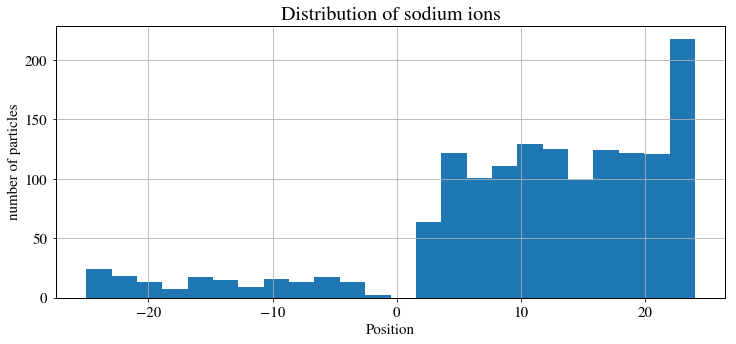

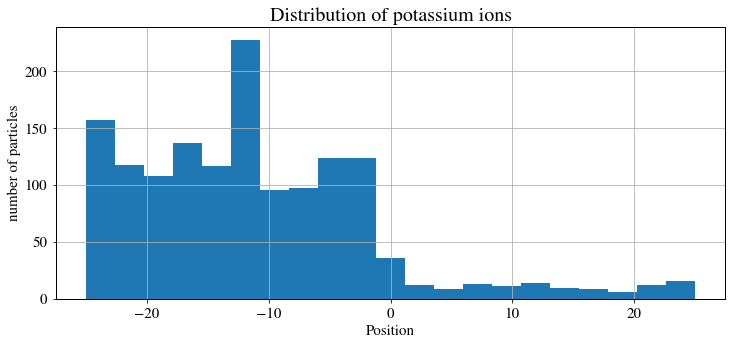

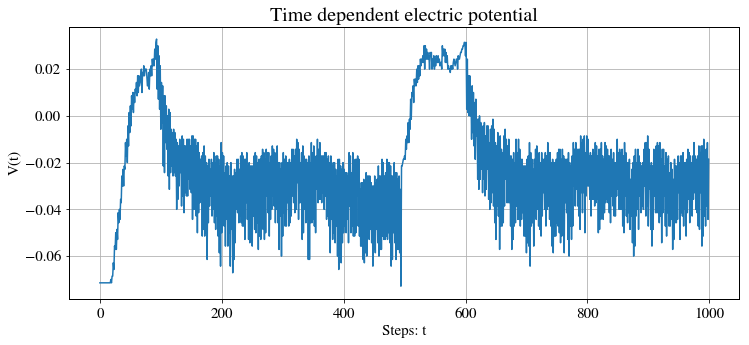

In [12]:
'''task 8.1'''
prep(50, 50, 1000)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K, True)


Our system goes through 1-3 cycles before it stops shooting voltage signals. Initially the sodium gate is opened since the voltage is less than or equal to $-70 mV$. The system then acts similarly to what happened in task 7.2, with a closed potassium gate, until the voltage reaches the maximum value and the potassium gate opens while the sodium gate closes. The voltage now settles around a similar value as the same case from 7.2. The voltage may reach the minimum value again sparking another shooting voltage signal or settle without reaching the minimum value through our system.

### 8.2 - Sodium Potassium Pump
Finally the sodium potassium pump is included. For every 10th time step, 2 potassium ions are transported from the outside of the cell inside, while 3 sodium ions are transported from the inside to the outside. If there are too few potassium or sodium ions for the pump to execute, the pump waits until there are enough before pumping and then waits 10 steps before the next pump. 

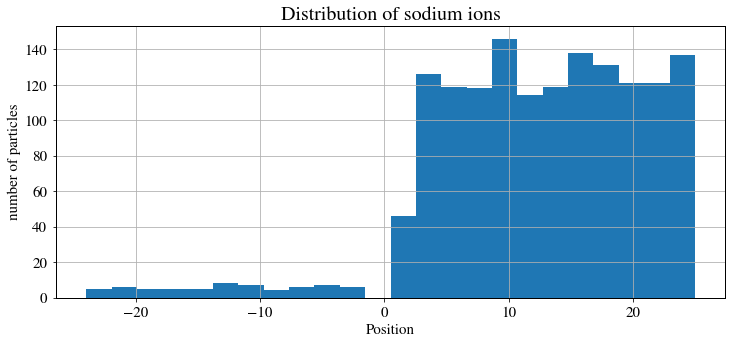

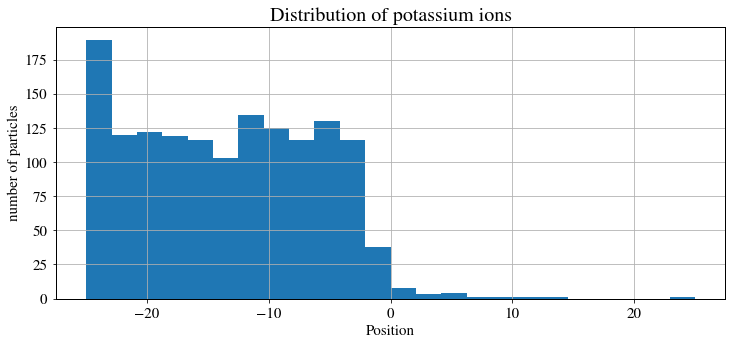

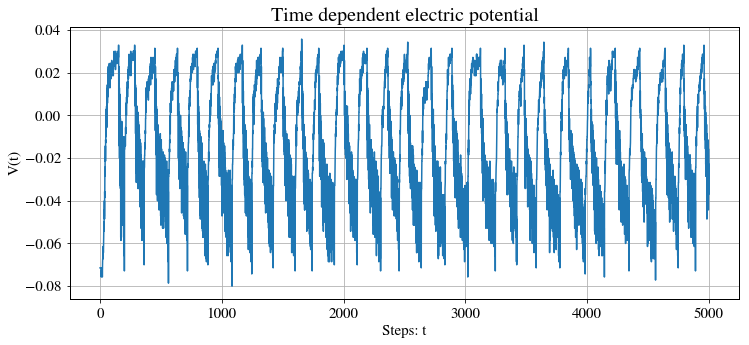

In [13]:
'''task 8.2'''
prep(50, 50, 5000)
plot_dist(Na_pos, K_pos, pos_vec, V_elec, P_min, V_channel, timesteps, betaV0_Na, betaV0_K, True, True)


When including the pump, it's apparent from the plot that the cycle continues. As seen in 8.1 the sodium gate is opened until the maximum voltage is reached. Instead of settling above the minimum voltage, the pump lowers the voltage by pumping sodium ions outside through membrane lowering the concentration. The minimum voltage is then reached repeating the cycle.

Now that all components are present, one can observe how the action potential is simulated. By repeatedly polarizing and depolarizing the cell as seen in the above plot its possible that neighbouring cells also gets depolarized, propagating an electric signal through a neural network.

## References
- Simensen, H. T. (2019). Prosjekt 3 - TMA 4320: Simulating the action potential with random walk of ions